In [14]:
# British Airways Flight Booking Prediction
# Author: Hayley M
# Year: 2026
#
# Objective:
# Build a machine learning model to predict whether a customer completes a flight booking.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin

import optuna
from optuna.integration import OptunaSearchCV

import matplotlib.pyplot as plt
import warnings

## 1. Data Loading

In [2]:
cbdf_raw = pd.read_csv('customer_booking.csv', encoding='ISO-8859-1')
cbdf = cbdf_raw.copy(deep=True)

cbdf.head(10)

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0
5,1,Internet,RoundTrip,3,48,20,Thu,AKLDEL,New Zealand,1,0,1,5.52,0
6,3,Internet,RoundTrip,201,33,6,Thu,AKLDEL,New Zealand,1,0,1,5.52,0
7,2,Internet,RoundTrip,238,19,14,Mon,AKLDEL,India,1,0,1,5.52,0
8,1,Internet,RoundTrip,80,22,4,Mon,AKLDEL,New Zealand,0,0,1,5.52,0
9,1,Mobile,RoundTrip,378,30,12,Sun,AKLDEL,India,0,0,0,5.52,0


## 2. Initial Data Exploration

Basic structural checks on the dataset including shape, data types, and summary statistics.

In [3]:
#Basic dataset overview
cbdf.shape
cbdf.head(3)
cbdf.info()
cbdf.describe(include="all").T

<class 'pandas.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  str    
 2   trip_type              50000 non-null  str    
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  str    
 7   route                  50000 non-null  str    
 8   booking_origin         50000 non-null  str    
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), str(5)
memory usage: 5.3 MB


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
num_passengers,50000.0,NaN,NaN,NaN,1.59124,1.020165,1.0,1.0,1.0,2.0,9.0
sales_channel,50000,2,Internet,44382,NaN,NaN,NaN,NaN,NaN,NaN,NaN
trip_type,50000,3,RoundTrip,49497,NaN,NaN,NaN,NaN,NaN,NaN,NaN
purchase_lead,50000.0,NaN,NaN,NaN,84.94048,90.451378,0.0,21.0,51.0,115.0,867.0
length_of_stay,50000.0,NaN,NaN,NaN,23.04456,33.88767,0.0,5.0,17.0,28.0,778.0
flight_hour,50000.0,NaN,NaN,NaN,9.06634,5.41266,0.0,5.0,9.0,13.0,23.0
flight_day,50000,7,Mon,8102,NaN,NaN,NaN,NaN,NaN,NaN,NaN
route,50000,799,AKLKUL,2680,NaN,NaN,NaN,NaN,NaN,NaN,NaN
booking_origin,50000,104,Australia,17872,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wants_extra_baggage,50000.0,NaN,NaN,NaN,0.66878,0.470657,0.0,0.0,1.0,1.0,1.0


## 3. Feature Engineering

In [4]:
class FeatureEngineer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.route_stats = None
        self.origin_stats = None
        self.channel_stats = None
        self.trip_type_stats = None
        self.origin_route_stats = None

    def fit(self, X, y=None):
        X_ = X.copy()
        if y is not None:
            cbdf = X_.copy()
            cbdf["booking_complete"] = y.values

            self.route_stats = cbdf.groupby("route")["booking_complete"].mean().to_dict()
            self.origin_stats = cbdf.groupby("booking_origin")["booking_complete"].mean().to_dict()
            self.channel_stats = cbdf.groupby("sales_channel")["booking_complete"].mean().to_dict()
            self.trip_type_stats = cbdf.groupby("trip_type")["booking_complete"].mean().to_dict()

            cbdf["origin_route"] = cbdf["booking_origin"] + "_" + cbdf["route"]
            self.origin_route_stats = cbdf.groupby("origin_route")["booking_complete"].mean().to_dict()
        return self

    def transform(self, X):
        cbdf = X.copy()

        cbdf["lead_times_stay"] = cbdf["purchase_lead"] * cbdf["length_of_stay"]
        cbdf["lead_div_stay"] = cbdf["purchase_lead"] / (cbdf["length_of_stay"] + 1)

        cbdf["route_booking_rate"] = cbdf["route"].map(self.route_stats)
        cbdf["booking_origin_booking_rate"] = cbdf["booking_origin"].map(self.origin_stats)
        cbdf["sales_channel_booking_rate"] = cbdf["sales_channel"].map(self.channel_stats)
        cbdf["trip_type_booking_rate"] = cbdf["trip_type"].map(self.trip_type_stats)

        cbdf["origin_route"] = cbdf["booking_origin"] + "_" + cbdf["route"]
        cbdf["origin_route_booking_rate"] = cbdf["origin_route"].map(self.origin_route_stats)
        cbdf.drop(columns=["origin_route"], inplace=True)

        return cbdf

In [5]:
numeric_features = ['purchase_lead', 'length_of_stay', 'flight_hour', 'flight_duration', 'lead_times_stay', 'lead_div_stay']
categorical_features = ['sales_channel', 'trip_type', 'flight_day']
binary_features = ['wants_extra_baggage', 'wants_preferred_seat', 'wants_in_flight_meals']
stat_features = ['route_booking_rate', 'booking_origin_booking_rate', 'sales_channel_booking_rate',
                 'trip_type_booking_rate', 'origin_route_booking_rate']

# Transformers
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Preprocessing pipeline
preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features),
    ('bin', 'passthrough', binary_features),
    ('stat', 'passthrough', stat_features)
])

# Full pipeline
full_pipeline = Pipeline(steps=[
    ('feature_engineering', FeatureEngineer()),
    ('preprocessing', preprocessor)
])

## 4. Model Training

In [6]:
X = cbdf.drop(columns=["booking_complete"])
y = cbdf["booking_complete"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Fit pipeline and transform
full_pipeline.fit(X_train, y_train)
X_train_trans = full_pipeline.transform(X_train)
X_test_trans = full_pipeline.transform(X_test)

In [7]:
baseline_rf = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
baseline_rf.fit(X_train_trans, y_train)

print("ROC AUC (baseline):", roc_auc_score(y_test, baseline_rf.predict_proba(X_test_trans)[:,1]))

ROC AUC (baseline): 0.7878243283437553


In [8]:
param_dist = {
    'n_estimators': [200, 300, 400, 500],
    'max_depth': [None, 10, 20, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

rnd_search = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=5,
    n_jobs=-1,
    verbose=2,
    random_state=42
)

rnd_search.fit(X_train_trans, y_train)
print("Best Randomized Params:", rnd_search.best_params_)
print("Best ROC AUC (CV):", rnd_search.best_score_)

best_rf = rnd_search.best_estimator_

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best Randomized Params: {'n_estimators': 400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced_subsample'}
Best ROC AUC (CV): 0.8404365458725549


## 5. Hyperparameter Optimisation (Optuna)

In [9]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 200, 600),
        'max_depth': trial.suggest_int('max_depth', 5, 50),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 15),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 8),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample'])
    }
    model = RandomForestClassifier(**params, random_state=42)
    score = cross_val_score(model, full_pipeline.transform(X), y, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10, show_progress_bar=True)

[I 2026-02-17 08:49:39,033] A new study created in memory with name: no-name-38a39ed9-4e9f-48b7-8ee8-573649f7a24a


  0%|          | 0/10 [00:00<?, ?it/s]

[I 2026-02-17 08:51:53,642] Trial 0 finished with value: 0.740604039751028 and parameters: {'n_estimators': 501, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.740604039751028.
[I 2026-02-17 08:53:59,089] Trial 1 finished with value: 0.6255743784068437 and parameters: {'n_estimators': 254, 'max_depth': 26, 'min_samples_split': 9, 'min_samples_leaf': 3, 'max_features': 'log2', 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: 0.740604039751028.
[I 2026-02-17 09:00:07,080] Trial 2 finished with value: 0.6251703483034092 and parameters: {'n_estimators': 328, 'max_depth': 15, 'min_samples_split': 2, 'min_samples_leaf': 7, 'max_features': 'sqrt', 'class_weight': 'balanced'}. Best is trial 0 with value: 0.740604039751028.
[I 2026-02-17 09:02:39,198] Trial 3 finished with value: 0.6376133287137725 and parameters: {'n_estimators': 386, 'max_depth': 33, 'min_samples_spli

In [10]:
print("Best Bayesian Params:", study.best_trial.params)
print("Best Bayesian ROC AUC:", study.best_trial.value)

optuna_rf = RandomForestClassifier(**study.best_trial.params, random_state=42)
optuna_rf.fit(X_train_trans, y_train)

Best Bayesian Params: {'n_estimators': 501, 'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8, 'max_features': 'sqrt', 'class_weight': 'balanced_subsample'}
Best Bayesian ROC AUC: 0.740604039751028


,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",501
,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.Note: This parameter is tree-specific.",'gini'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",5
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",8
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",8
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: {""sqrt"", ""log2"", None}, int or float, default=""sqrt""The number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... versionchanged:: 1.1 The default of `max_features` changed from `""auto""` to `""sqrt""`.Note: the search for a split does not stop until at least onevalid partition of the node samples is found, even if it requires toeffectively inspect more than ``max_features`` features.",'sqrt'
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow trees with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current node, ``N_t_L`` is the number of samples in theleft child, and ``N_t_R`` is the number of samples in the right child.``N``, ``N_t``, ``N_t_R`` and ``N_t_L`` all refer to the weighted sum,if ``sample_weight`` is passed... versionadded:: 0.19",0.0
,"bootstrap bootstrap: bool, default=TrueWhether bootstrap samples are used when building trees. If False, thewhole dataset is used to build each tree.",True
,"oob_score oob_score: bool or callable, default=FalseWhether to use out-of-bag samples to estimate the generalization score.By default, :func:`~sklearn.metrics.accuracy_score` is used.Provide a callable with signature `metric(y_

## 6. Model Evaluation


In [11]:
y_pred_opt = optuna_rf.predict(X_test_trans)
y_proba_opt = optuna_rf.predict_proba(X_test_trans)[:,1]

print("Classification Report:\n", classification_report(y_test, y_pred_opt))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_opt))
print("ROC AUC (Optimized):", roc_auc_score(y_test, y_proba_opt))

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.69      0.79      8504
           1       0.30      0.74      0.42      1496

    accuracy                           0.70     10000
   macro avg       0.62      0.72      0.61     10000
weighted avg       0.84      0.70      0.74     10000

Confusion Matrix:
 [[5855 2649]
 [ 382 1114]]
ROC AUC (Optimized): 0.7887409699619179


## 7. Feature Importance Analysis


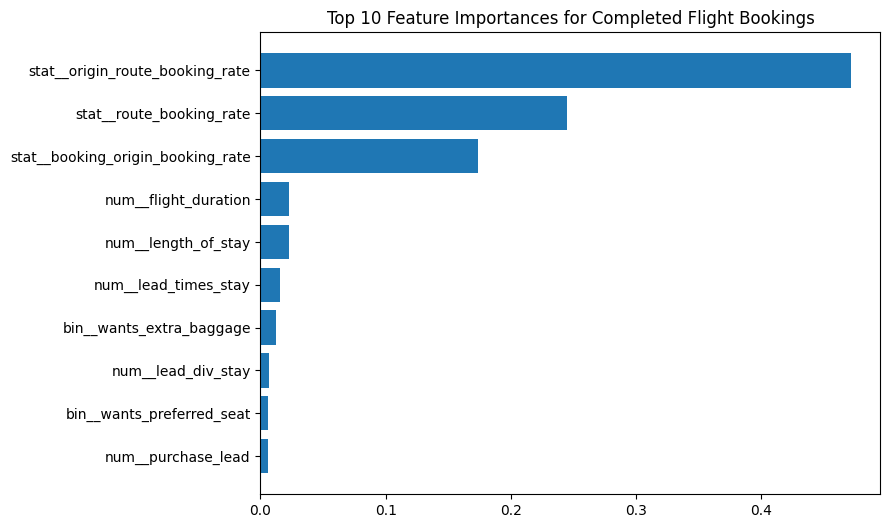

In [12]:
importances = optuna_rf.feature_importances_
feat_names = full_pipeline.named_steps["preprocessing"].get_feature_names_out()

indices = np.argsort(importances)[-10:]
plt.figure(figsize=(8,6))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feat_names[i] for i in indices])
plt.title("Top 10 Feature Importances for Completed Flight Bookings")
plt.savefig("Feature_Importance_BA.png", dpi=300)
plt.show()